# Respiratory Disease Classification
***
## Table of Contents
***

In [28]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
import os
import warnings
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
from PIL import Image

from numpy.typing import NDArray
from torchvision import datasets, transforms, models
from torchinfo import summary
from torchmetrics import Accuracy, F1Score
from pathlib import Path
from sklearn.metrics import confusion_matrix, classification_report
from torch.utils.data import DataLoader, Subset, Dataset

In [29]:
# Set a seed for reproducibility.
random_seed = 42
random.seed(random_seed)
np.random.seed(random_seed)
torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)
torch.cuda.manual_seed_all(random_seed)

## 1. Introduction


## 2. Device Agnostic Code
Mac GPU acceleration (`mps` backend) delivers significant speed-up over CPU for deep learning tasks, especially for large models and batch sizes. On Windows, `cuda` is used instead of `mps`.

In [30]:
# DEVICE = torch.device(
#     device="cuda" if torch.cuda.is_available() else "cpu"
# )  # For Windows
DEVICE = torch.device(
    device="mps" if torch.backends.mps.is_available() else "cpu"
)  # For MacOS
DEVICE

device(type='mps')

## 3. Loading Data
Retrieved from [COVID-19 Radiography Database](https://www.kaggle.com/datasets/tawsifurrahman/covid19-radiography-database/data)

In [31]:
DATA_PATH = Path("_datasets/Radiography_Dataset")

if DATA_PATH.is_dir():
    print(f"{DATA_PATH} directory exists.")
else:
    print(f"{DATA_PATH} directory NOT FOUND!")

_datasets/Radiography_Dataset directory exists.


In [32]:
def walk_through_dir(dir_path: str) -> None:
    """
    Print the number of directories and image files in each subdirectory of a given directory.

    Args:
        dir_path: Path to the root directory to walk through.
    """

    for (
        directory_path,
        directory_names,
        file_names,
    ) in os.walk(top=dir_path):
        print(
            f"{len(directory_names)} directories and {len(file_names)} images found in {directory_path}"
        )

In [33]:
walk_through_dir(DATA_PATH)

4 directories and 1 images found in _datasets/Radiography_Dataset
2 directories and 0 images found in _datasets/Radiography_Dataset/Viral Pneumonia
0 directories and 1345 images found in _datasets/Radiography_Dataset/Viral Pneumonia/images
0 directories and 1345 images found in _datasets/Radiography_Dataset/Viral Pneumonia/masks
2 directories and 0 images found in _datasets/Radiography_Dataset/Lung_Opacity
0 directories and 6012 images found in _datasets/Radiography_Dataset/Lung_Opacity/images
0 directories and 6012 images found in _datasets/Radiography_Dataset/Lung_Opacity/masks
2 directories and 0 images found in _datasets/Radiography_Dataset/Normal
0 directories and 10192 images found in _datasets/Radiography_Dataset/Normal/images
0 directories and 10192 images found in _datasets/Radiography_Dataset/Normal/masks
2 directories and 0 images found in _datasets/Radiography_Dataset/COVID
0 directories and 3616 images found in _datasets/Radiography_Dataset/COVID/images
0 directories and 3

In [34]:
class CustomDataset(Dataset):
    img_folder: str
    transform: transforms.Compose
    extensions: set[str]
    all_paths: list[str]
    all_labels: list[str]
    categories = set[str]
    label2id = dict[str, int]
    id2label = dict[int, str]
    all_labels_indices = list[int]

    def __init__(
        self, img_path, transform=None, extensions={".png", ".jpg", ".jpeg"}
    ) -> None:
        img_folder = "*/images/*"
        self.img_path = img_path
        self.transform = transform
        self.all_paths = [
            path
            for path in img_path.glob(img_folder)
            if path.suffix.lower() in extensions
        ]
        # All labels (2 folder levels above)
        self.all_labels = [path.parent.parent.name for path in self.all_paths]
        self.categories = sorted(set(self.all_labels))  # Unique labels
        self.label2id = {label: index for index, label in enumerate(self.categories)}
        self.id2label = {index: label for label, index in self.label2id.items()}
        self.all_labels_indices = [self.label2id[label] for label in self.all_labels]

    def __len__(self) -> int:
        return len(self.all_paths)

    def __getitem__(self, index):
        single_file_path = self.all_paths[index]
        try:
            img = Image.open(fp=single_file_path).convert(mode="RGB")
        except Exception as e:
            print(f"Error opening image {single_file_path}: {e}")
        label_index = self.all_labels_indices[index]

        if self.transform:
            img = self.transform(img)
        return img, label_index


In [35]:
dataset = CustomDataset(img_path=DATA_PATH)

## 4. Understanding Data

In [36]:
def show_random_images(dataset: Dataset) -> None:
    cols, rows = 3, 3
    figure = plt.figure(figsize=(rows * 3, cols * 3))
    for i in range(1, cols * rows + 1):
        sample_index = random.randint(a=0, b=len(dataset))
        img, label = dataset[sample_index]
        figure.add_subplot(rows, cols, i)
        plt.title(dataset.id2label[label])
        plt.axis("off")
        plt.tight_layout()
        plt.imshow(img)
    plt.show()

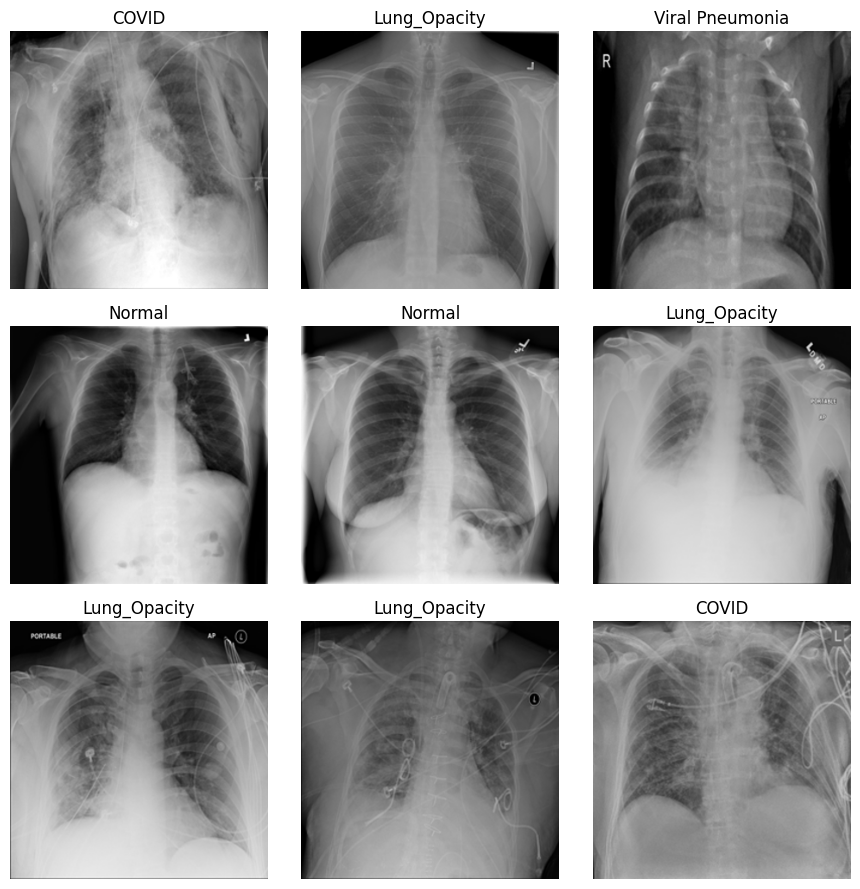

In [37]:
show_random_images(dataset)

In [38]:
dataset.id2label

{0: 'COVID', 1: 'Lung_Opacity', 2: 'Normal', 3: 'Viral Pneumonia'}

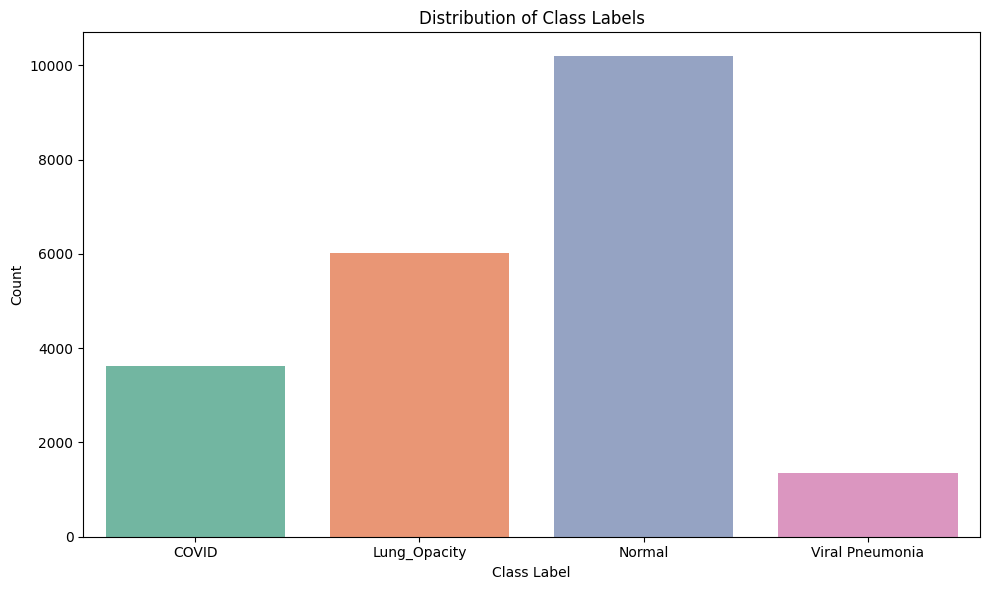

In [41]:
def plot_distribution(dataset: Dataset) -> None:
    unique_vals, counts = np.unique(dataset.all_labels, return_counts=True)
    df_dist = pd.DataFrame({"Class Label": unique_vals, "Count": counts})
    plt.figure(figsize=(10, 6))
    sns.barplot(data=df_dist, x='Class Label', y='Count', hue='Class Label', palette='Set2')
    plt.xlabel("Class Label")
    plt.ylabel("Count")
    plt.title("Distribution of Class Labels")
    plt.tight_layout()
    plt.show()


plot_distribution(dataset)